In [1]:
## TASK2 GENERATING ADVERSARIAL SAMPLES

In [1]:
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
headers = ['timestamp','duration','protocol', 'src_ip', 'src_port', 'direction', 'dst_ip' , 'dst_port'
           ,'state', 'src_type', 'dst_type' , 'total_packets', 'bytes_bothdir', 'bytes_onedir', 'label']

df_train_original = pd.read_csv("training_data_with_labels.csv", names=headers, header=None).sample(frac=0.05, replace=False, random_state=42).fillna(-1)
#df_val_notsampled = pd.read_csv("A2_2/valid_data_with_labels.csv", names=val_headers, header=None).fillna(-1)
df_test_original = pd.read_csv("test_data_with_labels.csv", names=headers, header=None).fillna(-1)

print('DONE')

DONE


In [3]:
print(len(df_train_original))

98908


In [4]:
train_headers = ['timestamp','duration','protocol', 'src_ip', 'src_port', 'direction', 'dst_ip' , 'dst_port'
           ,'state', 'src_type', 'dst_type' , 'total_packets', 'bytes_bothdir', 'bytes_onedir']

df_train_original['label']= df_train_original['label'].apply(str)
df_train_original.loc[df_train_original['label'].str.contains("From-Botnet"), 'label'] = -1
df_train_original.loc[df_train_original['label'].str.contains("From-Botnet")== False, 'label'] = 1
df_train_original.label = df_train_original.label.astype(int)

df_test_original['label']= df_test_original['label'].apply(str)
df_test_original.loc[df_test_original['label'].str.contains("From-Botnet"), 'label'] = -1
df_test_original.loc[df_test_original['label'].str.contains("From-Botnet")== False, 'label'] = 1
df_test_original.label = df_test_original.label.astype(int)


In [27]:
#X_train = df_train_sampled
X_train_ori = df_train_original
X_test_ori = df_test_original
print(len(X_train_ori))
print(len(X_test_ori))

98908
574383


In [6]:
## Preprocessing for calculation, and preparing for onehot 
def convert_to_str(df):
    convert_to_str_list = ['src_port', 'dst_port']
    for column in convert_to_str_list: 
        df[column]= df[column].apply(str)

    df_obj = df.select_dtypes(['object'])
    df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    
def apply_stat(df):
    df['pps'] = df['total_packets']/ df['duration']
    df['bps_onedir'] = df['bytes_onedir']/ df['total_packets']
    df['bpp_onedir'] = df['bytes_onedir']/ df['duration']
    df['bps_bothdir'] = df['bytes_bothdir']/ df['total_packets']
    df['bpp_bothdir'] = df['bytes_bothdir']/ df['duration']  
    
def preprocess(flag, df_original):
    groupby_columns = ['src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol']
    df_original["stream_id"] = df_original.groupby(groupby_columns).grouper.group_info[0]
    df_original = df_original.sort_values(by=['stream_id','timestamp'])
    df_original['timestamp']=df_original['timestamp'].apply(pd.to_datetime)
    #df['endtime'] = df['timestamp'] + pd.to_timedelta(df['duration'], unit='s')
    df_original.loc[df_original['duration']==0, 'duration'] = 0.000001
    #apply_addinfo(df)    
    convert_to_str(df_original)    
    stream_id_grouped = df_original.groupby(['stream_id'])    
    stream_id = stream_id_grouped.grouper.group_info[0]
    stream_id = set(stream_id)
    newdf = pd.DataFrame(stream_id, columns=['stream_id'])
    newdf['src_ip'] = stream_id_grouped['src_ip'].first()
    newdf['dst_ip'] = stream_id_grouped['dst_ip'].first()
    newdf['src_port'] = stream_id_grouped['src_port'].first()
    newdf['dst_port'] = stream_id_grouped['dst_port'].first()
    newdf['protocol'] = stream_id_grouped['protocol'].first()
    
    if flag == 'val':
        newdf['label'] = stream_id_grouped['label'].mean()

    return newdf, df_original

In [7]:
%%time
## FOR FEATURE3: average cumulative features

src_time_diff_dict = {}
src_cnt_dict = {}
dst_time_diff_dict = {}
dst_cnt_dict = {}
srcdst_time_diff_dict = {}
srcdst_cnt_dict = {}

def get_time_diff(df_original):

    df_original['src_time_diff']= df_original.groupby('src_ip')['timestamp'].apply(lambda s: s.diff().dt.seconds < 60)
    df_original['dst_time_diff']= df_original.groupby('dst_ip')['timestamp'].apply(lambda s: s.diff().dt.seconds < 60)
    df_original['srcdst_time_diff']= df_original.groupby(['src_ip', 'dst_port'])['timestamp'].apply(lambda s: s.diff().dt.seconds < 30) 
    
def groupby_sum(df, df_original):
    fields = ['bytes_bothdir','bytes_onedir', 'total_packets', 'duration']

    for field in fields:
        df[field] = df_original.groupby(['stream_id'])[field].sum()
    
    return df

def apply_avg(df, df_original):
    df['pps'] = df['total_packets']/df['duration']
    df['bps_onedir'] = df['bytes_onedir']/ df['total_packets']
    df['bpp_onedir'] = df['bytes_onedir']/ df['duration']
    df['bps_bothdir'] = df['bytes_bothdir']/ df['total_packets']
    df['bpp_bothdir'] = df['bytes_bothdir']/ df['duration']    
    return df

def cnt_timed_src(df, df_original):  
    src_time_diff_dict = df_original.groupby('src_ip')['src_time_diff'].sum().to_dict()
    #dst_cnt_dict = df_original.groupby('src_ip')['dst_ip'].count().to_dict()

    df['cnt_timed_src']=df.apply(lambda x: src_time_diff_dict[x.src_ip], axis=1)
    #df['cnt_dst']=df.apply(lambda x: dst_cnt_dict[x.src_ip], axis=1)
    return df

def cnt_timed_dst(df, df_original ):
    dst_time_diff_dict = df_original.groupby('dst_ip')['dst_time_diff'].sum().to_dict()
    #src_cnt_dict = df_original.groupby('dst_ip')['src_ip'].count().to_dict()
    df['cnt_timed_dst']=df.apply(lambda x: dst_time_diff_dict[x.dst_ip], axis=1)
    #df['cnt_src']=df.apply(lambda x: src_cnt_dict[x.dst_ip], axis=1)
    return df

def get_dict(dictionary):
    newdict={}
    for (k1, k2), count in dictionary.items():
        if k1 in newdict:
            if count>0:
                newdict[k1] +=1
        else:
            newdict[k1] = 0
    return newdict
    
def cnt_timed_srcdst(df, df_original):    
    srcdst_time_diff_dict = df_original.groupby(['src_ip', 'dst_port' ])['srcdst_time_diff'].sum().to_dict() 
    srcdst_time_diff_dict = get_dict(srcdst_time_diff_dict)
    #srcdst_cnt_dict = df_original.groupby(['src_ip', 'dst_port'])['src_ip'].count().to_dict()
    #srcdst_cnt_dict = get_dict(srcdst_cnt_dict)
    df['cnt_timed_srcdst']=df.apply(lambda x: srcdst_time_diff_dict[x.src_ip], axis=1)
    #df['cnt_srcdst']=df.apply(lambda x: srcdst_cnt_dict[x.src_ip], axis=1)
    return df

Wall time: 0 ns


In [8]:
scaler = StandardScaler()

def apply_scaler(df):
    df_columns_to_scale = df[columns_to_scale]
    train_scaled_features  = scaler.fit_transform(df_columns_to_scale) 
    train_scaled_features_df = pd.DataFrame( train_scaled_features, index=df_columns_to_scale.index, columns=columns_to_scale)

    return train_scaled_features_df

def get_pc(X, num_components=2, tsne=False):

    if tsne:
        reduced_data = TSNE(n_components=num_components).fit_transform(X)
    else:
        pca = PCA(n_components=num_components, random_state=42).fit(X)
        print("PCA.explained variance_ratio_ :",sum(pca.explained_variance_ratio_) )
        reduced_data = pca.transform(X)
    
    return reduced_data


In [9]:
%%time

## cumulative featrues mostly by grouped by [src_ip, dst_ip, src_port, dst_port, protocol]
def get_feature3(flag, df_original):           

    df, df_original = preprocess(flag, df_original)
    df[['starttime', 'endtime']] = df_original.groupby(['stream_id']).agg(starttime=('timestamp', 'min'), endtime=('timestamp', 'max'))    
    df = groupby_sum(df, df_original)    
    df = apply_avg(df, df_original)  
    get_time_diff(df_original)
    df = cnt_timed_src(df, df_original)
    df = cnt_timed_dst(df, df_original)
    df = cnt_timed_srcdst(df, df_original)   
    print(flag , 'DONE')
    
    return df


Wall time: 0 ns


In [24]:
X_train.head()

,bytes_bothdir,bytes_onedir,total_packets,duration,pps,bps_onedir,bpp_onedir,bps_bothdir,bpp_bothdir,cnt_timed_src,cnt_timed_dst,cnt_timed_srcdst
0,-0.03916,-0.026629,-0.041634,-0.211271,0.657007,-0.424921,0.381812,-0.636037,1.063197,-0.880234,-1.004642,-1.677192
1,-0.03916,-0.026629,-0.041634,-0.211271,-0.275575,-0.424921,-0.297139,-0.636037,-0.301503,-0.880234,-1.004642,-1.677192
2,-0.03916,-0.026629,-0.041634,-0.211271,-0.264796,-0.424921,-0.289291,-0.636037,-0.285729,-0.880234,-1.004642,-1.677192
3,-0.03916,-0.026629,-0.041634,-0.211271,-0.269122,-0.424921,-0.292441,-0.636037,-0.292060,-0.880234,-1.004642,-1.677192
4,-0.03916,-0.026629,-0.041634,-0.211271,-0.247980,-0.424921,-0.277048,-0.636037,-0.261121,-0.880234,-1.004642,-1.677192


In [35]:
%%time
print('Generating features... ')
df_train_f3 = get_feature3('val', X_train_ori) 
print('train len: ', len(df_train_f3))
Y = X_train_ori['label']
print('DONE')

Generating features... 
val DONE
train len:  70584
DONE
Wall time: 29 s


In [50]:
feature3 = ['bytes_bothdir', 'bytes_onedir', 'total_packets', 'duration', 
             'pps', 'bps_onedir', 'bpp_onedir', 'bps_bothdir', 'bpp_bothdir', 
             'cnt_timed_src', 'cnt_timed_dst', 'cnt_timed_srcdst']

selected_features = feature3
columns_to_scale = feature3

df_train_f3[columns_to_scale] = apply_scaler(df_train_f3)
X_train = df_train_f3[selected_features]
#X = get_pc(X_train, 3)
X = X_train
Y = df_train_f3['label']

print('DONE')

DONE


In [51]:
Y

0        1
1        1
2        1
3        1
4        1
        ..
70579    1
70580    1
70581    1
70582    1
70583    1
Name: label, Length: 70584, dtype: int32

In [58]:
class logistic_regression(object):
    def fit(self, X, Y, learning_rate=0.0000003, epoch=1000):
        X = np.array(X, dtype="float32")
        Y = np.array(Y, dtype="float32")

        N, D = X.shape
        Y = Y.reshape(N, 1)

        dlt = np.zeros([N, 1], dtype="float32")
        dW = np.zeros([1, D], dtype="float32")
        db = 0
        self.weight = np.zeros([D, 1], dtype="float32")
        self.beta = 0

        c = []

        for n in range(epoch):
            dlt = self.predict(X).T - Y
            dW = np.matmul(dlt.T, X).T
            db = dlt.sum() / N

            self.weight -= learning_rate * dW
            self.beta -= learning_rate * db
            '''
            if n % 200 == 0:
                c_new = cost(self.predict(X).T, Y)
                c.append(c_new)
                err = error_rate(self.predict_class(X).T, Y)
                print("epoch:", n, "cost:", c_new, "error rate:", err)
            '''
    def predict(self, X):
        z = np.matmul(self.weight.T, X.T) + self.beta
        return 1 / (1 + np.exp(-z))

    def predict_class(self, X):
        predictclass = self.predict(X)
        return (predictclass >= 0.5) * 1
                
    def predict(self, X):
        z = np.matmul(self.weight.T, X.T) + self.beta
        return 1 / (1 + np.exp(-z))

    def predict_class(self, X):
        predictclass = self.predict(X)
        return (predictclass >= 0.5) * 1
                
def error_rate(P, Y):
    return np.mean(Y != P)

def adversial_samples(X, Y, model, epsilon=0.00001):
    dlt = model.predict(X).T - Y.reshape(X.shape[0], 1)
    direction = np.sign(np.matmul(dlt, model.weight.T))
    return X + epsilon * direction, Y

def cost(Y_hat, Y):
    Y_hat = Y_hat.flatten()
    Y = Y.flatten()
    cost1 = 0
    elp = 0.0000000000000000000000000000000000000000000001
    for i in range(len(Y)):
        cost1 -= Y[i] * np.log(Y_hat[i] + elp) + (1 - Y[i]) * np.log(1 - Y_hat[i] + elp)
    return cost1


model = logistic_regression()
#model = LogisticRegression()
#model.fit(X, Y)
X = np.array(X)
Y = np.array(Y)

In [59]:
np.array(X)

array([[-0.03916046, -0.02662853, -0.04163367, ..., -0.88023427,
        -1.00464185, -1.67719155],
       [-0.03916046, -0.02662853, -0.04163367, ..., -0.88023427,
        -1.00464185, -1.67719155],
       [-0.03916046, -0.02662853, -0.04163367, ..., -0.88023427,
        -1.00464185, -1.67719155],
       ...,
       [-0.03500942, -0.02413222, -0.02837064, ..., -0.93701282,
        -1.00364406, -1.67719155],
       [-0.03483064, -0.01978513, -0.02173912, ..., -0.93701282,
        -1.00364406, -1.67719155],
       [-0.02660855, -0.00600252,  0.00611324, ..., -0.93701282,
        -1.00464185, -1.67719155]])

In [60]:
def show_adversarials(epoch_num, X, Y):
    print('Epoch: ', epoch_num)
    model.fit(X, Y, learning_rate=0.0005,  epoch=epoch_num) #20000
    print('Error Rate without adversarial examples:', error_rate(model.predict_class(X).T, Y.reshape(X.shape[0], 1)))
    print()
    
    Xadv, Y = adversial_samples(X, Y, model, epsilon=0.2)
    print('Error Rate with adversarial examples, epsilon = 0.2:', error_rate(model.predict(Xadv).T, Y.reshape(Xadv.shape[0], 1)))
    Xadv2, Y = adversial_samples(X, Y, model, epsilon=0.5)
    print('Error Rate with adversarial examples, epsilon = 0.5:', error_rate(model.predict(Xadv2).T, Y.reshape(Xadv2.shape[0], 1)))

    plt.scatter(X[:9999, 0], X[:9999, 1], color='blue', alpha=0.4, label='Original Data')
    plt.scatter(Xadv[:9999, 0], Xadv[:9999, 1], color='green', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
    plt.scatter(Xadv2[:9999, 0], Xadv2[:9999, 1], color='purple', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
    plt.scatter(X[10000:, 0], X[10000:, 1], color='red', alpha=0.4, label='Original Data')
    plt.scatter(Xadv[10000:, 0], Xadv[10000:, 1], color='orange', alpha=0.4, label='Adversarial Examples, Epsilon = 0.2')
    plt.scatter(Xadv2[10000:, 0], Xadv2[10000:, 1], color='yellow', alpha=0.4, label='Adversarial Examples, Epsilon = 0.5')
    plt.legend(loc='best')
    plt.show()
    return Xadv, Xadv2

Epoch:  1
Error Rate without adversarial examples: 0.43446106766405984

Error Rate with adversarial examples, epsilon = 0.2: 0.9842598889266689
Error Rate with adversarial examples, epsilon = 0.5: 0.9842598889266689


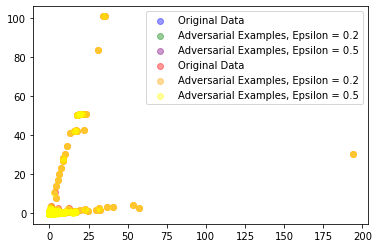

In [61]:
Xadv, Xadv2 = show_adversarials(1, X, Y)

In [62]:
Xadv

array([[-0.23916046, -0.22662853, -0.24163367, ..., -1.08023427,
        -1.20464185, -1.47719155],
       [-0.23916046, -0.22662853, -0.24163367, ..., -1.08023427,
        -1.20464185, -1.47719155],
       [-0.23916046, -0.22662853, -0.24163367, ..., -1.08023427,
        -1.20464185, -1.47719155],
       ...,
       [-0.23500942, -0.22413222, -0.22837064, ..., -1.13701282,
        -1.20364406, -1.47719155],
       [-0.23483064, -0.21978513, -0.22173912, ..., -1.13701282,
        -1.20364406, -1.47719155],
       [-0.22660855, -0.20600252, -0.19388676, ..., -1.13701282,
        -1.20464185, -1.47719155]])

In [66]:
adv_df = pd.DataFrame(data=Xadv, columns=selected_features)

In [107]:
adv_df

,bytes_bothdir,bytes_onedir,total_packets,duration,pps,bps_onedir,bpp_onedir,bps_bothdir,bpp_bothdir,cnt_timed_src,cnt_timed_dst,cnt_timed_srcdst
0,-0.239160,-0.226629,-0.241634,-0.411271,0.857007,-0.624921,0.581812,-0.836037,1.263197,-1.080234,-1.204642,-1.477192
1,-0.239160,-0.226629,-0.241634,-0.411271,-0.075575,-0.624921,-0.097139,-0.836037,-0.101503,-1.080234,-1.204642,-1.477192
2,-0.239160,-0.226629,-0.241634,-0.411271,-0.064796,-0.624921,-0.089291,-0.836037,-0.085729,-1.080234,-1.204642,-1.477192
3,-0.239160,-0.226629,-0.241634,-0.411271,-0.069122,-0.624921,-0.092441,-0.836037,-0.092060,-1.080234,-1.204642,-1.477192
4,-0.239160,-0.226629,-0.241634,-0.411271,-0.047980,-0.624921,-0.077048,-0.836037,-0.061121,-1.080234,-1.204642,-1.477192
...,...,...,...,...,...,...,...,...,...,...,...,...
70579,-0.182166,-0.065463,-0.148792,-0.410621,-0.093707,5.178864,-0.105856,1.639140,-0.123185,-1.137013,-1.204642,-1.477192
70580,-0.182166,-0.065463,-0.148792,-0.410637,-0.093696,5.178864,-0.105733,1.639140,-0.123045,-1.137013,-1.204642,-1.477192
70581,-0.235009,-0.224132,-0.228371,-0.375802,-0.094151,-0.397497,-0.110662,0.109711,-0.128681,-1.137013,-1.203644,-1.477192
70582,-0.234831,-0.219785,-0.221739,-0.409902,-0.094103,0.121771,-0.110563,-0.229110,-0.128482,-1.137013,-1.203644,-1.477192


In [70]:
X_train_original = df_train_f3
X_train_mod = df_train_f3.copy()
X_train_mod[selected_features] = adv_df

In [76]:
X_train_original.src_ip.value_counts()[:10]

147.32.84.138     14775
147.32.84.59      13401
147.32.84.229      3480
147.32.85.25       1973
147.32.86.20       1307
147.32.85.34       1214
147.32.84.170       779
147.32.84.94        774
147.147.98.151      602
147.124.93.156      599
Name: src_ip, dtype: int64

In [88]:
train_anomaly = X_train_original[X_train_original['label']==-1]

In [93]:
train_anomaly.src_ip.value_counts()[:10]

147.147.98.151     602
147.124.93.156     599
147.37.96.153      582
147.236.100.149    581
147.32.84.192      581
147.231.96.180     579
147.175.101.148    570
147.177.96.192     560
147.74.98.178      555
147.94.93.195      552
Name: src_ip, dtype: int64

In [94]:
bot_df = X_train_original[X_train_original['src_ip']=='147.147.98.151'] 

In [102]:
bot_df = X_train_original[X_train_original['src_ip']=='147.32.84.138']
len(bot_df)

14775

In [87]:
anomaly = df_train_original['label']==-1

98908

In [100]:
train_bot_df = bot_df[selected_features]

In [106]:
train_bot_df.head()

,bytes_bothdir,bytes_onedir,total_packets,duration,pps,bps_onedir,bpp_onedir,bps_bothdir,bpp_bothdir,cnt_timed_src,cnt_timed_dst,cnt_timed_srcdst
15428,-0.037733,-0.023699,-0.031023,-0.122413,-0.294152,0.052320,-0.310663,-0.397636,-0.328687,-0.277976,-1.004642,-0.386971
15429,-0.038419,-0.025559,-0.033676,-0.211261,-0.290957,-0.368939,-0.308027,-0.557725,-0.322911,-0.277976,-0.922823,-0.386971
15430,0.725562,0.038679,0.609581,-0.211178,-0.272881,-0.475452,-0.297041,4.516604,0.184591,-0.277976,-0.922823,-0.386971
15431,0.174108,-0.007072,0.150680,-0.211251,-0.265529,-0.469858,-0.292055,4.164975,0.317727,-0.277976,-0.922823,-0.386971
15432,-0.038444,-0.025559,-0.033676,-0.211259,-0.291577,-0.368939,-0.308538,-0.568814,-0.324157,-0.277976,-0.922823,-0.386971


In [104]:
bot_pred = model.predict_class(np.array(train_bot_df))
bot_pred

array([[1, 1, 0, ..., 1, 1, 1]])

In [105]:
unique, counts = np.unique(bot_pred, return_counts=True)
print (np.asarray((unique, counts)).T)

[[    0    37]
 [    1 14738]]


Epoch:  10
Error Rate without adversarial examples: 0.4140315085571801

Error Rate with adversarial examples, epsilon = 0.2: 0.5039810721976652
Error Rate with adversarial examples, epsilon = 0.5: 0.5039810721976652


C:\Users\kebin\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: overflow encountered in exp


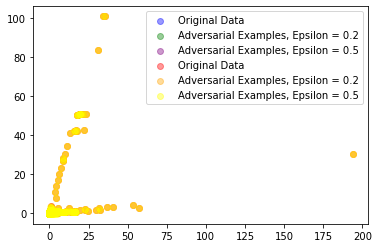

(array([[-0.23916046, -0.22662853, -0.24163367, ..., -1.08023427,
         -1.20464185, -1.47719155],
        [-0.23916046, -0.22662853, -0.24163367, ..., -1.08023427,
         -1.20464185, -1.47719155],
        [-0.23916046, -0.22662853, -0.24163367, ..., -1.08023427,
         -1.20464185, -1.47719155],
        ...,
        [-0.23500942, -0.22413222, -0.22837064, ..., -1.13701282,
         -1.20364406, -1.47719155],
        [-0.23483064, -0.21978513, -0.22173912, ..., -1.13701282,
         -1.20364406, -1.47719155],
        [-0.22660855, -0.20600252, -0.19388676, ..., -1.13701282,
         -1.20464185, -1.47719155]]),
 array([[-0.53916046, -0.52662853, -0.54163367, ..., -1.38023427,
         -1.50464185, -1.17719155],
        [-0.53916046, -0.52662853, -0.54163367, ..., -1.38023427,
         -1.50464185, -1.17719155],
        [-0.53916046, -0.52662853, -0.54163367, ..., -1.38023427,
         -1.50464185, -1.17719155],
        ...,
        [-0.53500942, -0.52413222, -0.52837064, ..., -

In [64]:
show_adversarials(10, X, Y)